# Mount Google drive

In [1]:
# Mount Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME = 'Colab Notebooks/StylingModel/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# download the dataset to Drive
# if it doesn't already exist.
# %cd /content/drive/My\ Drive/$FOLDERNAME/datasets/
# !bash get_datasets.sh
# %cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive


# Load & Visualizing Dataset

In [2]:
from PIL import Image

# Open the TIFF image file
image = Image.open(f"/content/drive/My Drive/{FOLDERNAME}/datasets/m38432.tiff")

# Get the resolution (width and height) of the image
width, height = image.size

print("Image resolution (width x height):", width, "x", height)

# Optionally, you can also print other image properties
print("Image mode:", image.mode)  # Mode can be "RGB", "RGBA", "L" (grayscale), etc.


Image resolution (width x height): 500 x 750
Image mode: RGB


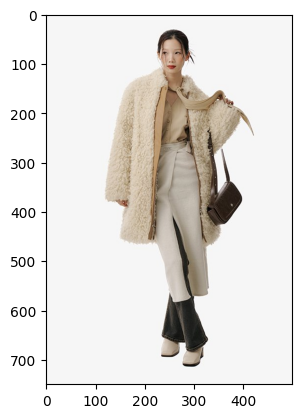

In [3]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(image)
# plt.axis('off')  # Hide axes
plt.show()


# Model

In [4]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.cluster import KMeans
import numpy as np
import os


## Data transformer

In [5]:
# Define data transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 336)),
    transforms.ToTensor(),
])


## Backbone Model - VGG

In [6]:
# Load pre-trained VGG model
vgg_model = models.vgg16(pretrained=True)
# Remove the last classification layer
vgg_model.classifier = torch.nn.Sequential(*list(vgg_model.classifier.children())[:-1])
# Set the model to evaluation mode
vgg_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.2MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
# Function to extract features from an image
def extract_features(image_path, model):
    image = Image.open(image_path)
    image = data_transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(image)
    return features.numpy().flatten()  # Flatten the feature tensor to a 1D array


In [8]:
# List of image paths

# Define the categories and their corresponding directories
categories = ['chic', 'dandy', 'gorp', 'retro']
base_dir = f"/content/drive/My Drive/{FOLDERNAME}/datasets/musinsa/"

images = []
for category in categories:
  # Get the directory path for the current category
  category_dir = os.path.join(base_dir,f"m_{category}_images")
  files = os.listdir(category_dir)
  images.extend([os.path.join(category_dir, file) for file in files])
print(len(images))

4088


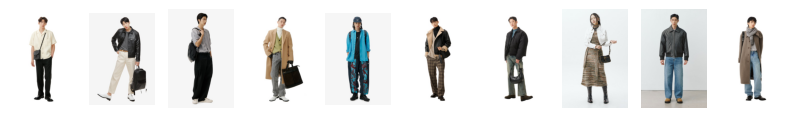

In [9]:
import random

# Visualize some random outfits from the dataset
random_images = random.sample(images, 10)

fig = plt.figure(figsize=(10, 8))
for idx, image_path in enumerate(random_images):
    plt_idx = idx + 1  # Adjust index to start from 1
    plt.subplot(1, 10, plt_idx)
    plt.imshow(Image.open(image_path))
    plt.axis('off')
plt.show()


# Test Model

120


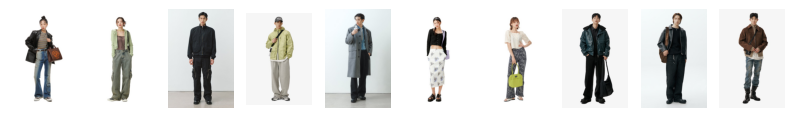

In [32]:
test_images = []


# Define the number of images to select from each category
num_images_per_category = 30

# Iterate over each category
for category in categories:
    # Get the directory path for the current category
    category_dir = os.path.join(base_dir,f"m_{category}_images")

    # Get a list of all image filenames in the category directory
    image_files = os.listdir(category_dir)

    # Select `num_images_per_category` images randomly
    images_files = random.sample(image_files, num_images_per_category)
    test_images.extend([os.path.join(category_dir, file) for file in images_files])
print(len(test_images))

# Visualize some random outfits from the dataset
random_images = random.sample(test_images, 10)

fig = plt.figure(figsize=(10, 8))
for idx, image_path in enumerate(random_images):
    plt_idx = idx + 1  # Adjust index to start from 1
    plt.subplot(1, 10, plt_idx)
    plt.imshow(Image.open(image_path))
    plt.axis('off')
plt.show()



In [33]:
# Extract features from the image
test_feature_vectors = []
for test_image in test_images:
  print(f"extracting image named : {test_image}")
  test_features = extract_features(test_image, vgg_model)
  test_feature_vectors.append(test_features)
#Convert to Numpy array
test_feature_vectors = np.array(test_feature_vectors)

extracting image named : /content/drive/My Drive/Colab Notebooks/StylingModel//datasets/musinsa/m_chic_images/39681.jpg
extracting image named : /content/drive/My Drive/Colab Notebooks/StylingModel//datasets/musinsa/m_chic_images/40835.jpg
extracting image named : /content/drive/My Drive/Colab Notebooks/StylingModel//datasets/musinsa/m_chic_images/39501.jpg
extracting image named : /content/drive/My Drive/Colab Notebooks/StylingModel//datasets/musinsa/m_chic_images/37296.jpg
extracting image named : /content/drive/My Drive/Colab Notebooks/StylingModel//datasets/musinsa/m_chic_images/38971.jpg
extracting image named : /content/drive/My Drive/Colab Notebooks/StylingModel//datasets/musinsa/m_chic_images/39337.jpg
extracting image named : /content/drive/My Drive/Colab Notebooks/StylingModel//datasets/musinsa/m_chic_images/33876.jpg
extracting image named : /content/drive/My Drive/Colab Notebooks/StylingModel//datasets/musinsa/m_chic_images/37456.jpg
extracting image named : /content/drive/

In [34]:
# Perform clustering on the features

# Apply k-means clustering
num_clusters = len(categories)
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(test_feature_vectors)

# Get cluster labels for each image
cluster_labels = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


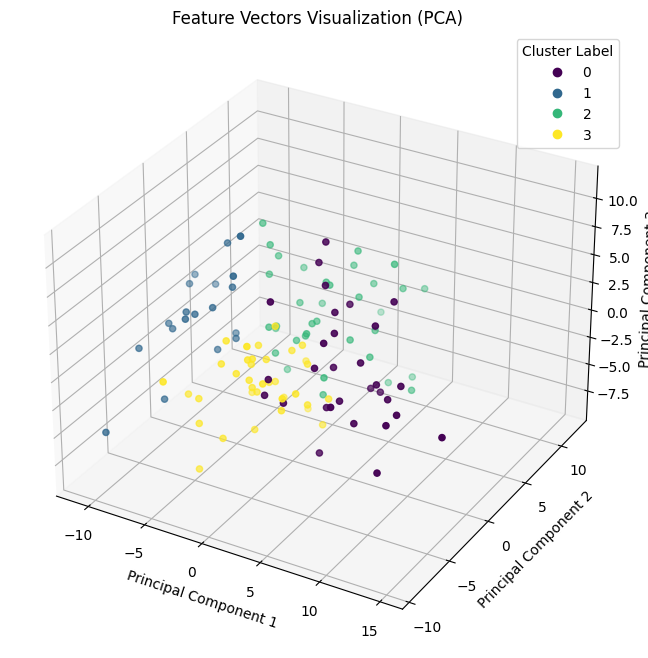

In [35]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Assuming feature_vectors is your numpy array of feature vectors
# Apply PCA to reduce dimensionality to 3 for visualization
pca = PCA(n_components=3)
feature_vectors_3d = pca.fit_transform(test_feature_vectors)

# Plot the 3D feature vectors
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(feature_vectors_3d[:, 0], feature_vectors_3d[:, 1], feature_vectors_3d[:, 2], c=cluster_labels, cmap='viridis')
ax.set_title('Feature Vectors Visualization (PCA)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend(*scatter.legend_elements(), title='Cluster Label')
plt.show()


In [36]:
# Analyze clustering results
# (e.g., count the number of images assigned to each cluster)

from collections import defaultdict

# Create a dictionary to store the count of images per category and cluster
category_cluster_counts = defaultdict(lambda: defaultdict(int))

# Iterate over each category and its corresponding images
for i, label in enumerate(cluster_labels):
    print(f"Image {i+1}: Cluster {label}")
    if i+1 <= num_images_per_category:
      category_cluster_counts['chic'][label]+=1
    elif i+1 <= num_images_per_category * 2:
      category_cluster_counts['dandy'][label]+=1
    elif i+1 <= num_images_per_category * 3:
      category_cluster_counts['gorp'][label]+=1
    else :
      category_cluster_counts['retro'][label]+=1

# Print the count of images per category and cluster
for category, cluster_counts in category_cluster_counts.items():
    print(f"Category: {category}")
    for cluster, count in cluster_counts.items():
        print(f"Cluster {cluster}: {count} images")

Image 1: Cluster 1
Image 2: Cluster 3
Image 3: Cluster 1
Image 4: Cluster 2
Image 5: Cluster 3
Image 6: Cluster 2
Image 7: Cluster 2
Image 8: Cluster 2
Image 9: Cluster 1
Image 10: Cluster 2
Image 11: Cluster 1
Image 12: Cluster 1
Image 13: Cluster 0
Image 14: Cluster 2
Image 15: Cluster 2
Image 16: Cluster 2
Image 17: Cluster 1
Image 18: Cluster 1
Image 19: Cluster 2
Image 20: Cluster 2
Image 21: Cluster 3
Image 22: Cluster 2
Image 23: Cluster 1
Image 24: Cluster 2
Image 25: Cluster 3
Image 26: Cluster 2
Image 27: Cluster 2
Image 28: Cluster 2
Image 29: Cluster 1
Image 30: Cluster 2
Image 31: Cluster 2
Image 32: Cluster 1
Image 33: Cluster 2
Image 34: Cluster 2
Image 35: Cluster 1
Image 36: Cluster 3
Image 37: Cluster 1
Image 38: Cluster 3
Image 39: Cluster 3
Image 40: Cluster 3
Image 41: Cluster 3
Image 42: Cluster 3
Image 43: Cluster 3
Image 44: Cluster 1
Image 45: Cluster 1
Image 46: Cluster 3
Image 47: Cluster 2
Image 48: Cluster 3
Image 49: Cluster 1
Image 50: Cluster 3
Image 51:

Category: m_chic_images
Cluster 1:


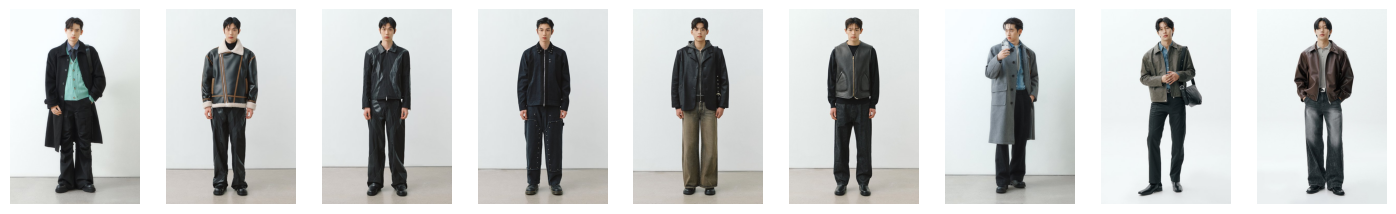


Cluster 3:


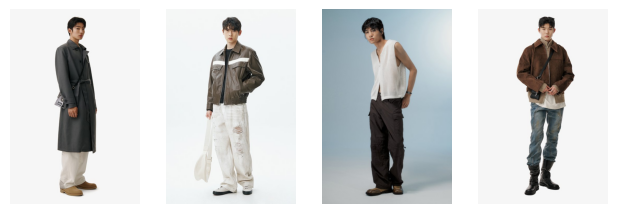


Cluster 2:


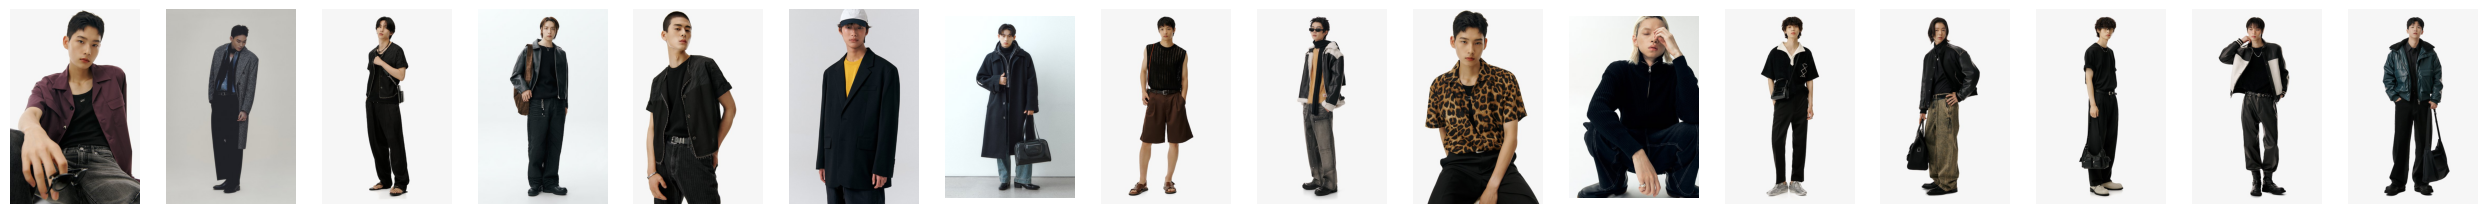


Cluster 0:


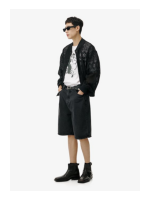


Category: m_dandy_images
Cluster 2:


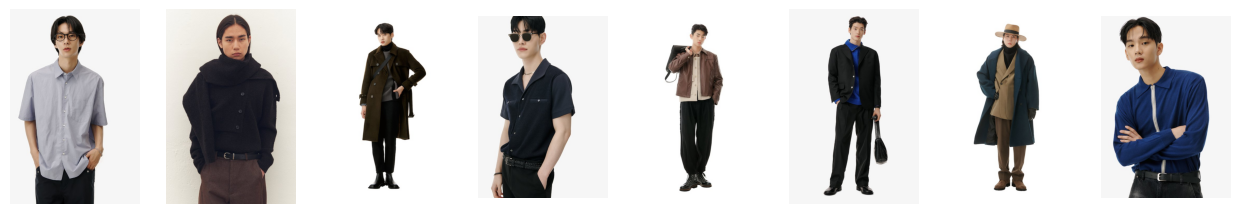


Cluster 1:


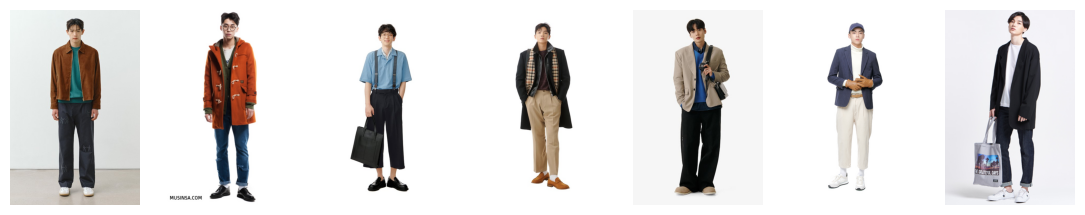


Cluster 3:


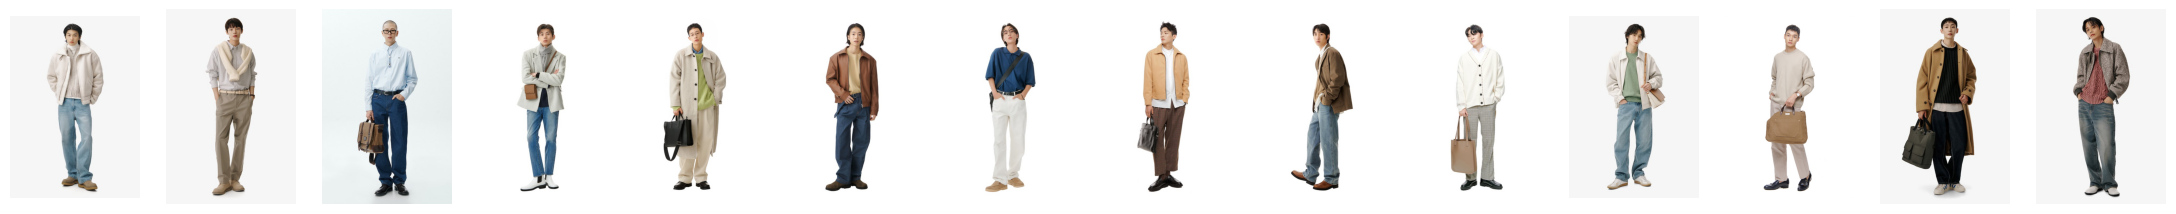


Cluster 0:


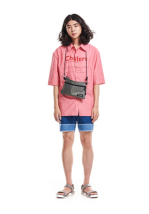


Category: m_gorp_images
Cluster 1:


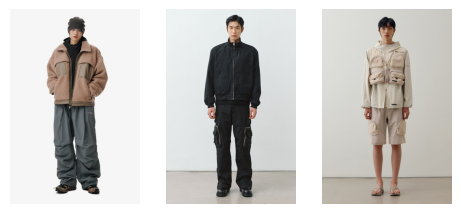


Cluster 2:


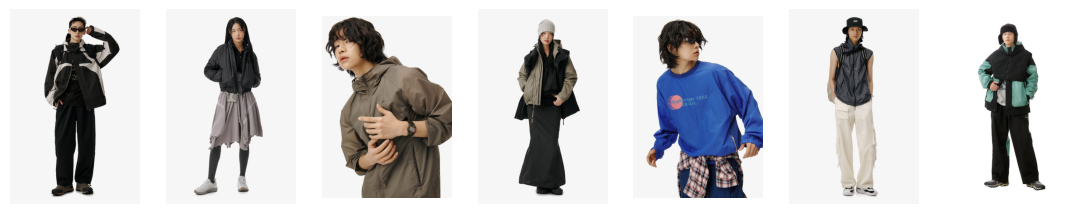


Cluster 3:


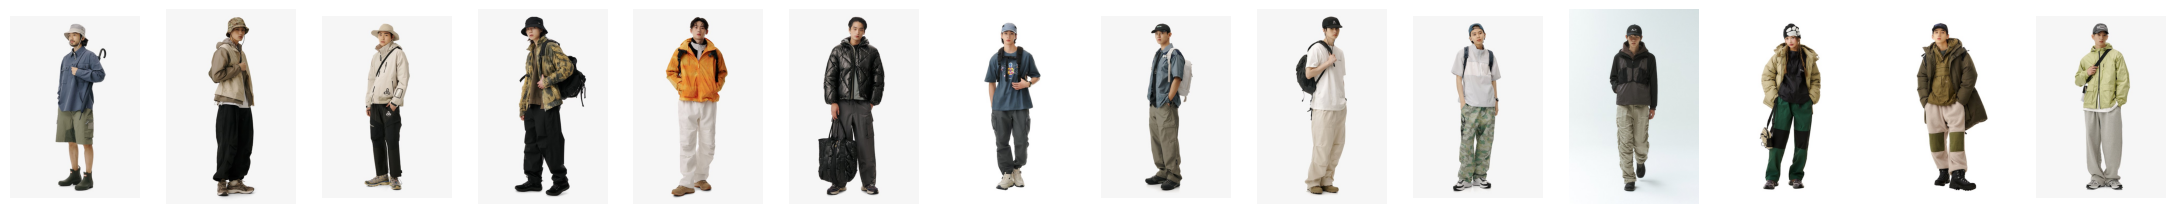


Cluster 0:


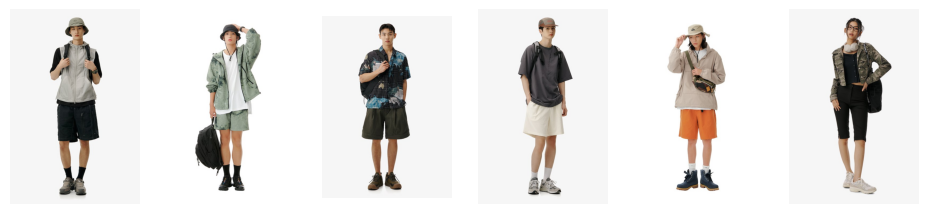


Category: m_retro_images
Cluster 0:


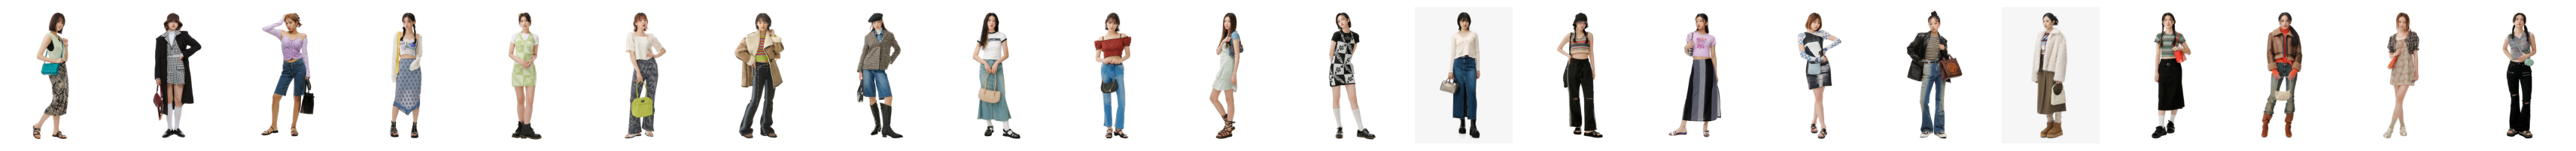


Cluster 2:


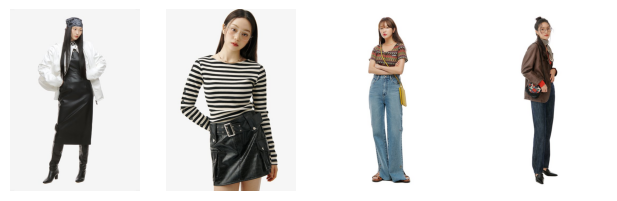


Cluster 3:


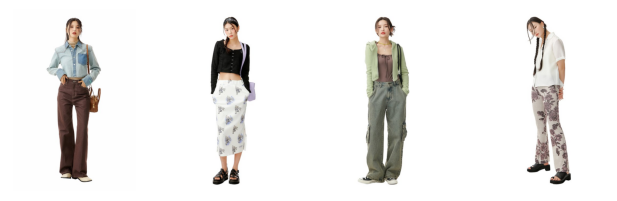

In [37]:
# Define the number of images to display per category-cluster combination
num_images_to_display = 30

# Create a dictionary to store image paths per category and cluster
category_cluster_images = defaultdict(lambda: defaultdict(list))

for i, (image_path, label) in enumerate(zip(test_images, cluster_labels)):
    category = image_path.split('/')[-2]
    category_cluster_images[category][label].append(image_path)

# Display sample images for each category-cluster combination
for category, cluster_images in category_cluster_images.items():
    print(f"Category: {category}")
    for cluster, images in cluster_images.items():
        print(f"Cluster {cluster}:")
        sample_images = random.sample(images, min(num_images_to_display, len(images)))
        fig = plt.figure(figsize=(60, 12))
        for idx, image_path in enumerate(sample_images):
            ax = fig.add_subplot(1, num_images_to_display, idx + 1)
            image = plt.imread(image_path)
            ax.imshow(image)
            ax.axis('off')
        plt.show()
        print()  # Print a blank line after each category-cluster combination

In [38]:
# Extract features from all images
feature_vectors = []
for image in images:
    print(f"extracting image named : {image}")
    features = extract_features(image, vgg_model)
    feature_vectors.append(features)

# Convert feature vectors to numpy array
feature_vectors = np.array(feature_vectors)



extracting image named : /content/drive/My Drive/Colab Notebooks/StylingModel//datasets/musinsa/m_retro_images/29024.jpg
extracting image named : /content/drive/My Drive/Colab Notebooks/StylingModel//datasets/musinsa/m_retro_images/20016.jpg
extracting image named : /content/drive/My Drive/Colab Notebooks/StylingModel//datasets/musinsa/m_retro_images/20932.jpg
extracting image named : /content/drive/My Drive/Colab Notebooks/StylingModel//datasets/musinsa/m_retro_images/21114.jpg


In [39]:
# Apply k-means clustering
num_clusters = len(categories)  # Example: number of clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(feature_vectors)

# Get cluster labels for each image
cluster_labels = kmeans.labels_

# Print cluster labels for each image
for i, label in enumerate(cluster_labels):
    print(f"Image {i+1}: Cluster {label}")

Image 1: Cluster 1
Image 2: Cluster 3
Image 3: Cluster 0
Image 4: Cluster 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Visualization

## PCA

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Assuming feature_vectors is your numpy array of feature vectors
# Apply PCA to reduce dimensionality to 3 for visualization
pca = PCA(n_components=3)
feature_vectors_3d = pca.fit_transform(feature_vectors)

# Plot the 3D feature vectors
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(feature_vectors_3d[:, 0], feature_vectors_3d[:, 1], feature_vectors_3d[:, 2], c=cluster_labels, cmap='viridis')
ax.set_title('Feature Vectors Visualization (PCA)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend(*scatter.legend_elements(), title='Cluster Label')
plt.show()


## Images per category, cluster